In [1]:
import os
import re
import PIL
import sys
import sls
import cv2
import json
import time
import glob
import math
import timm
import copy
import torch
import pickle
import geffnet
import logging
import fnmatch
import argparse
import itertools
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import torch.nn as nn
from PIL import Image
from glob import glob
from pathlib import Path
from copy import deepcopy
from sklearn import metrics
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
import torch.utils.model_zoo as model_zoo
from timm.models.layers.activations import *
%config InlineBackend.figure_format = 'retina'
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict, defaultdict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [2]:
data_dir = '/home/linh/Downloads/Covid-19'

# Define your transforms for the training and testing sets
data_transforms = {  
    'data':  transforms.Compose([
             #transforms.RandomRotation(30),
             transforms.Resize(256),
             #transforms.RandomResizedCrop(224),        
             transforms.CenterCrop(224),
             #transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                ]),
    'test':  transforms.Compose([
             #transforms.RandomRotation(30),
             transforms.Resize(256),
             #transforms.RandomResizedCrop(224),        
             transforms.CenterCrop(224),
             #transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                ])

                    }

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['data', 'test']}

batch_size = 4
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=4)
              for x in ['data', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['data']}

class_names = image_datasets['data'].classes
print(class_names)
print(dataset_sizes)
print(device)


### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['data'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
print(cat_to_name)
    
# Run this to test the data loader
images, labels = next(iter(data_loader['data']))
images.size()

['COVID-19', 'normal', 'pneumonia']
{'data': 15000}
cuda:0
{0: 'COVID-19', 1: 'normal', 2: 'pneumonia'}


torch.Size([4, 3, 224, 224])

# Modified EfficientNet_B0 with image size = 224

checkpoint loaded
prediction time for complete in 100017 milisecond
              precision    recall  f1-score   support

           0   0.987500  0.731481  0.840426       108
           1   0.944301  0.988363  0.965829      8851
           2   0.979491  0.917067  0.947251      6041

    accuracy                       0.957800     15000
   macro avg   0.970430  0.878970  0.917835     15000
weighted avg   0.958784  0.957800  0.957445     15000



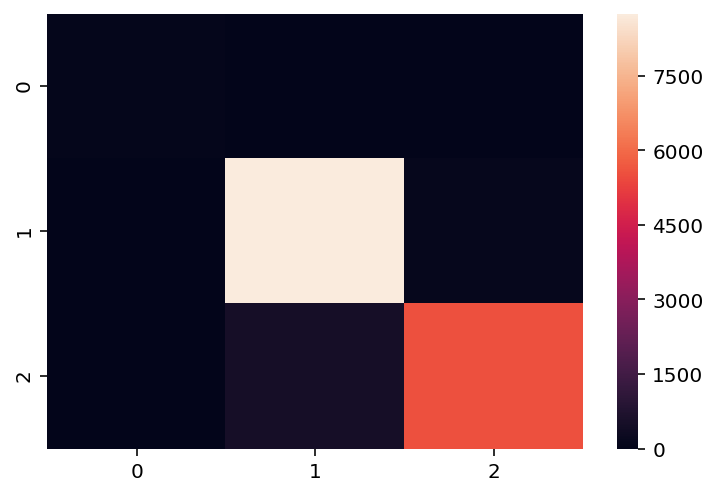

In [3]:
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('efficientnet_b0', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets

# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU
model.to(device)
CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/EfficientNet_B0_Covid-19.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH)  
since = round(time.monotonic() * 1000)

#since = time.time()
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['data']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/Modified_EfficienNet_B0_Covid-19_Whole_Data.csv',index=False)
time_elapsed = round(time.monotonic() * 1000) - since   

#time_elapsed = time.time() - since

#print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))

sns.heatmap(confusion_matrix(y_test, y_pred))
accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred, digits=6)
print(report)

# MixNet_XL with image size = 224

checkpoint loaded
prediction time for complete in 179726 milisecond
              precision    recall  f1-score   support

           0   0.990291  0.944444  0.966825       108
           1   0.974456  0.991300  0.982806      8851
           2   0.986594  0.962423  0.974359      6041

    accuracy                       0.979333     15000
   macro avg   0.983780  0.966056  0.974663     15000
weighted avg   0.979458  0.979333  0.979289     15000



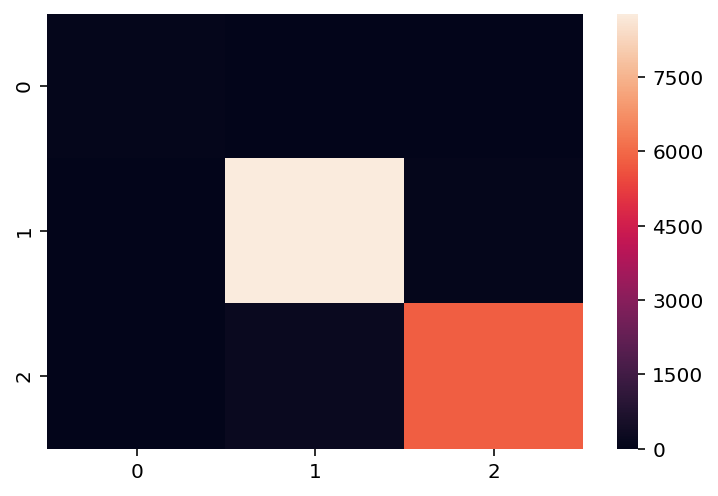

In [8]:
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('mixnet_xl', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets

# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(1536, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU
model.to(device)
CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/MixNet_Extra_Large_Covid-19.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH)  
since = round(time.monotonic() * 1000)

#since = time.time()
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['data']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/Modified_MixNet_Extra_Large_Covid-19_Whole_Dataset.csv',index=False)
time_elapsed = round(time.monotonic() * 1000) - since   

#time_elapsed = time.time() - since

#print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))

sns.heatmap(confusion_matrix(y_test, y_pred))
accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred, digits=6)
print(report)

# TResNet_Extra_Large with image size = 224

In [ ]:
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('tresnet_xl', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.head #show the classifier layer (fully connected layer) for EfficientNets

## Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
classifier = nn.Sequential(OrderedDict([#('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = classifier
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU
model.to(device)
CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/TResNet_Extra_Large_Covid-19.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH)  

since = round(time.monotonic() * 1000)
#since = time.time()
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['data']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/Modified_TResNet_Extra_Large_Covid-19_Whole_Data.csv',index=False)

#time_elapsed = time.time() - since
time_elapsed = round(time.monotonic() * 1000) - since   

#print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))

sns.heatmap(confusion_matrix(y_test, y_pred))
accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred, digits=6)
print(report)

# Ensemble voting of top-3 best models with image size = 224

In [4]:
def get_Eff_B0():
    model = timm.create_model('efficientnet_b0', pretrained=True)

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/EfficientNet_B0_Covid-19.pth'
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    return model
       

def get_MixNet_XL():
    model = timm.create_model('mixnet_xl', pretrained=True)
    model.classifier #show the classifier layer (fully connected layer) for EfficientNets

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(1536, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/MixNet_Extra_Large_Covid-19.pth'    
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    
    return model


def get_TResNet_XL():
    model = timm.create_model('tresnet_xl', pretrained=True)
    model.head #show the classifier layer (fully connected layer) for EfficientNets

    for param in model.parameters():
        param.requires_grad = True
   
    classifier = nn.Sequential(OrderedDict([#('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
    model.fc = classifier
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/TResNet_Extra_Large_Covid-19.pth'    
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.eval()
    
    return model

In [7]:
class Ensemble_Model(nn.Module):
    def __init__(self):
        super(Ensemble_Model, self).__init__()
        self.Eff_B0 = get_Eff_B0()
        self.MixNet_XL = get_MixNet_XL()
        self.TResNet_XL = get_TResNet_XL()
    def forward(self, x):
        x1 = self.Eff_B0(x)
        x2 = self.MixNet_XL(x)
        x3 = self.TResNet_XL(x)

        x = sum([x1, x2, x3]) / 3
        return x
    
model = Ensemble_Model()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)

100953089


prediction time for complete in 39940 milisecond
              precision    recall  f1-score   support

           0     1.0000    0.4000    0.5714        10
           1     0.9647    0.9876    0.9760       885
           2     0.9724    0.9478    0.9599       594

    accuracy                         0.9678      1489
   macro avg     0.9790    0.7785    0.8358      1489
weighted avg     0.9680    0.9678    0.9669      1489



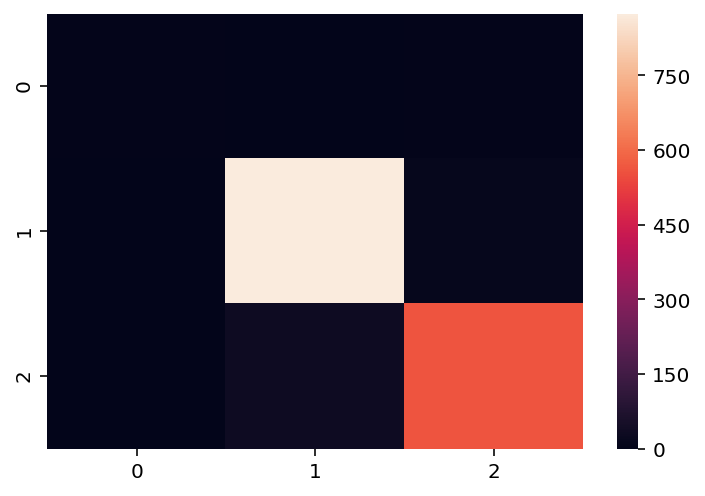

In [11]:
model.to(device)
#since = time.time()
since = round(time.monotonic() * 1000)
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['data']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())


#time_elapsed = time.time() - since
time_elapsed = round(time.monotonic() * 1000) - since   

#print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))

#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/Ensemble_Eff_B0_MixNet_XL_TResNet_XL_Whole_Data.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4)
print(report)

prediction time for complete in 397940 milisecond
              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565       108
           1     0.9722    0.9932    0.9826      8851
           2     0.9887    0.9589    0.9736      6041

    accuracy                         0.9789     15000
   macro avg     0.9870    0.9563    0.9709     15000
weighted avg     0.9791    0.9789    0.9788     15000



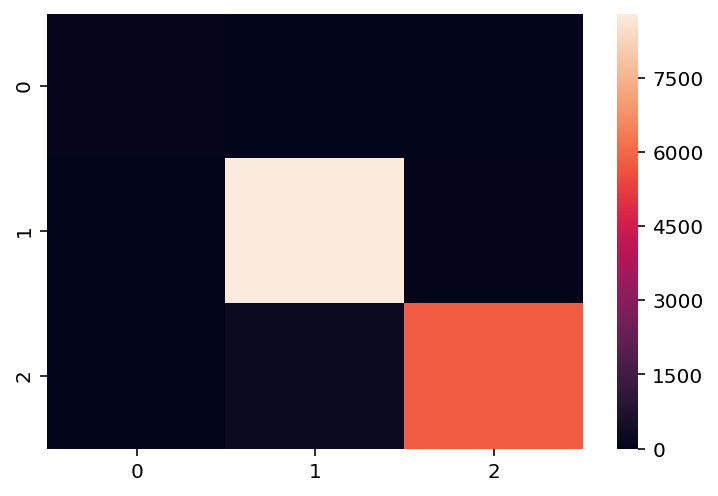

In [12]:
model.to(device)
#since = time.time()
since = round(time.monotonic() * 1000)
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['data']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())


#time_elapsed = time.time() - since
time_elapsed = round(time.monotonic() * 1000) - since   

#print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))

#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/Ensemble_Eff_B0_MixNet_XL_TResNet_XL_Whole_Data.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4)
print(report)

# Ensemble voting MixNet_XL and TResNet with image size = 224

In [5]:
class Ensemble_Model(nn.Module):
    def __init__(self):
        super(Ensemble_Model, self).__init__()
        #self.Eff_B0 = get_Eff_B0()
        self.MixNet_XL = get_MixNet_XL()
        self.TResNet_XL = get_TResNet_XL()
    def forward(self, x):
        #x1 = self.Eff_B0(x)
        x2 = self.MixNet_XL(x)
        x3 = self.TResNet_XL(x)
        x = sum([x2, x3]) / 2
        #x = sum([x1, x2, x3]) / 3
        return x
    
model = Ensemble_Model()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tresnet/tresnet_xl_82_0-a2d51b00.pth" to /home/linh/.cache/torch/checkpoints/tresnet_xl_82_0-a2d51b00.pth


93033698


# Inference on Testset using Ensemble voting of MixNet_XL and TResNet_XL

prediction time for complete in 33433 milisecond
              precision    recall  f1-score   support

           0     1.0000    0.4000    0.5714        10
           1     0.9677    0.9819    0.9748       885
           2     0.9659    0.9545    0.9602       594

    accuracy                         0.9671      1489
   macro avg     0.9779    0.7788    0.8355      1489
weighted avg     0.9672    0.9671    0.9662      1489



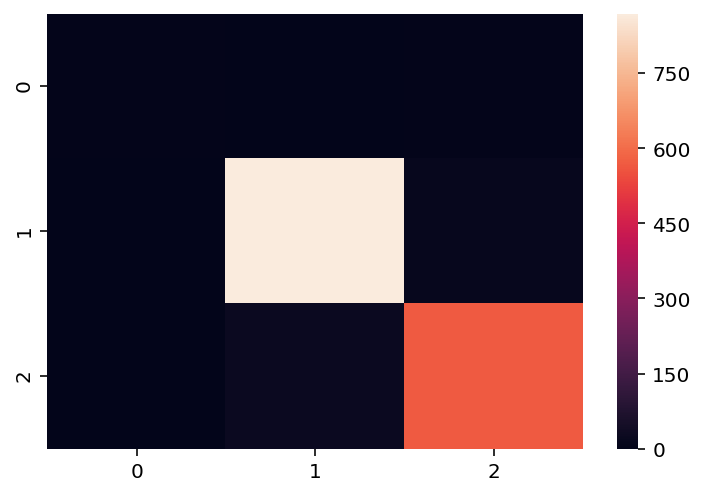

In [6]:
model.to(device)
#since = time.time()
since = round(time.monotonic() * 1000)
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['test']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())


#time_elapsed = time.time() - since
time_elapsed = round(time.monotonic() * 1000) - since   

#print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))

#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/MixNet_XL_TResNet_XL_Testset.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4)
print(report)

# Inference on whole dataset using Ensemble voting of MixNet_XL and TResNet_XL

prediction time for complete in 335005 milisecond
              precision    recall  f1-score   support

           0     1.0000    0.9259    0.9615       108
           1     0.9774    0.9923    0.9848      8851
           2     0.9877    0.9669    0.9772      6041

    accuracy                         0.9816     15000
   macro avg     0.9884    0.9617    0.9745     15000
weighted avg     0.9817    0.9816    0.9816     15000



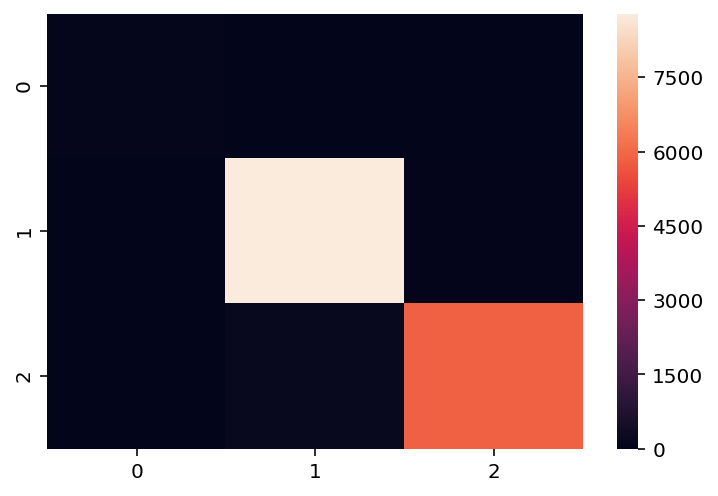

In [7]:
model.to(device)
#since = time.time()
since = round(time.monotonic() * 1000)
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['data']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())


#time_elapsed = time.time() - since
time_elapsed = round(time.monotonic() * 1000) - since   

#print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))

#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/MixNet_XL_TResNet_XL_Whole_Data.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4)
print(report)